In [0]:
# prerequisites
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras import optimizers
from scipy.stats import norm

Using TensorFlow backend.


In [0]:
# network parameters
batch_size= 100
n_epoch = 50
n_hidden = 256
z_dim = 2

In [0]:
# data load
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255.
x_train = x_train.reshape(x_train.shape[0], -1)

x_test = x_test.astype('float32')/255.
x_test = x_test.reshape(x_test.shape[0], -1)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# encoder
x = Input(shape=(x_train.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)
# reason for taking log_var
# https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig

In [0]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var / 2) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

In [0]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_train.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

In [0]:
def vae_loss(x, y) :
    reconstruction_loss = objectives.binary_crossentropy(x, y) * x_train.shape[1]
    # we multiply by x_train.shape[1] because binary_crossentropy calculates the average across all
    # inputs, while we just need the sum
    # so we multiply by x_train.shape[1] which in this case
    # is 784
    p = mu
    q = log_var
    m  = 0.5 * (p + q)

    kl_1 = 0.5 * K.sum(K.square(p) + K.exp(m) - m - 1, axis = -1)
    kl_2 = 0.5 * K.sum(K.square(q) + K.exp(m) - m - 1, axis = -1)

    js_loss = 0.5 * (kl_1 + kl_2)

    # we need to take mean because it is to be calculated for all samples in loss function
    vae_loss = K.mean(reconstruction_loss + js_loss)   
    return vae_loss

# build model
vae = Model(x, y)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
vae.compile(optimizer=adam, loss=vae_loss)
vae.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            258         dense_2[0][0]                 

In [0]:
# train
vae.fit(x_train, x_train,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_test, x_test), verbose=1)




Train on 60000 samples, validate on 10000 samples
Epoch 1/50





60000/60000 [==============================] - 12s 195us/step - loss: 193.7245 - val_loss: 171.8996
Epoch 2/50
60000/60000 [==============================] - 11s 179us/step - loss: 168.5481 - val_loss: 166.0434
Epoch 3/50
60000/60000 [==============================] - 11s 179us/step - loss: 163.6201 - val_loss: 162.2727
Epoch 4/50
60000/60000 [==============================] - 11s 177us/step - loss: 160.1803 - val_loss: 159.3007
Epoch 5/50
60000/60000 [==============================] - 11s 178us/step - loss: 157.9251 - val_loss: 157.2175
Epoch 6/50
60000/60000 [==============================] - 11s 179us/step - loss: 156.2868 - val_loss: 156.2458
Epoch 7/50
60000/60000 [==============================] - 11s 178us/step - loss: 155.0405 - val_loss: 155.0501
Epoch 8/50
60000/60000 [==============================] - 11s 178us/step - loss: 153.9810 - val_loss: 153.9743
Epoch 9/50
60000/60000 [==============================

In [0]:
# build encoder
encoder = Model(x, mu)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


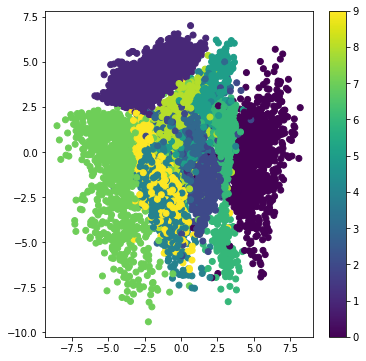

In [0]:
# Plot of the digit classes in the latent space
x_test_latent = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_latent[:, 0], x_test_latent[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [0]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


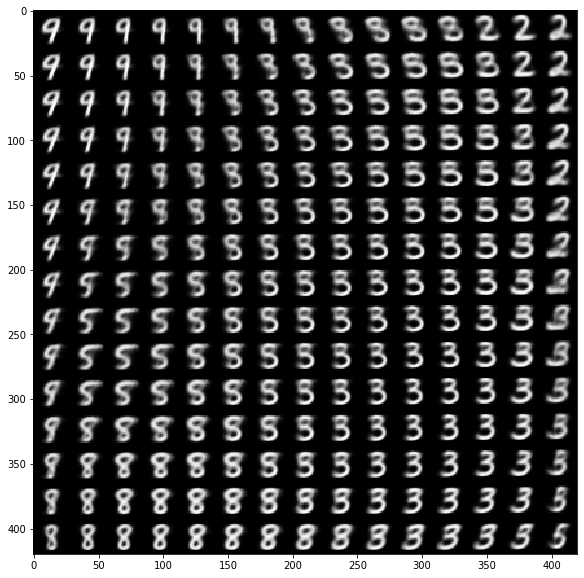

In [0]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# norm.ppf refers to the values which give the corresponding probabability in the argument
# norm.ppf takes normal distribution with mean 0. and stddev 1.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) # 1(batch_size) x 2(latent_dim)
        x_decoded = generator.predict(z_sample) # 784
        digit = x_decoded[0].reshape(digit_size, digit_size) # 28 x 28
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()